# **Morphology thinning**

In [1]:
import numpy as np
from PIL import Image
import cv2

In [2]:
from morphology import morphology_thinning

# **Original fingerprint**

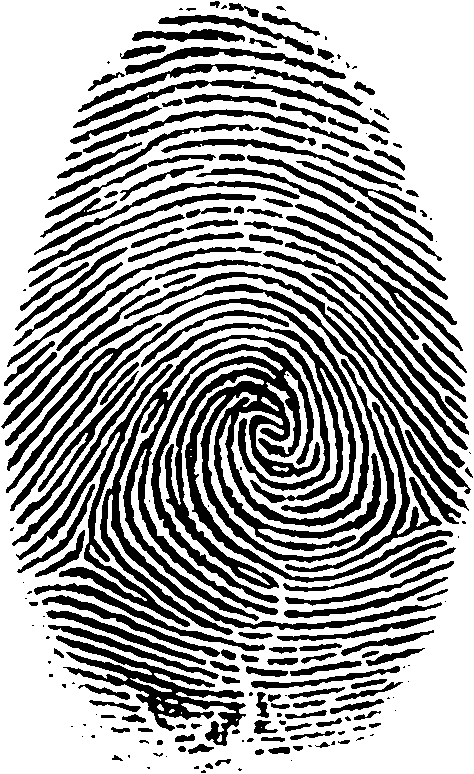

In [ ]:
image = Image.open(f'test_data/tester.bmp')
image_np = np.array(image)
_, farray = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
img = Image.fromarray(farray)
if farray.ndim == 3:
    farray = farray[:, :, 0]
img = Image.fromarray(farray)
img

# **Skeleton**

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


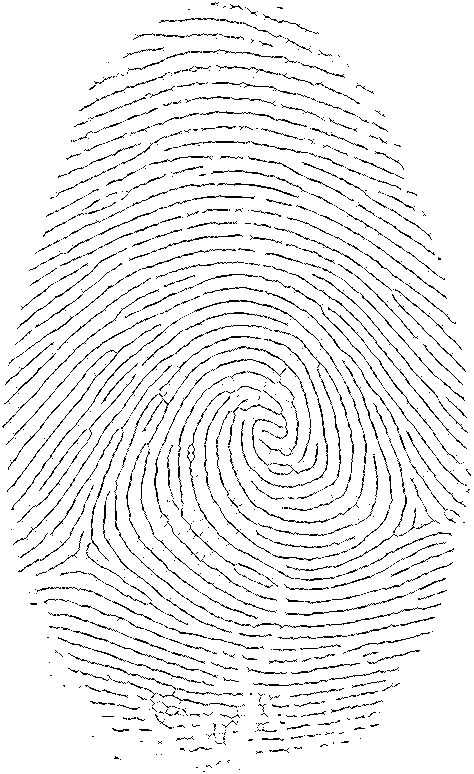

In [6]:
skeleton = morphology_thinning(farray, show = True)
skeleton[skeleton == 0] = 255
skeleton[skeleton == 1] = 0


skeleton = skeleton.astype(np.uint8)
img = Image.fromarray(skeleton)
img